<a href="https://colab.research.google.com/github/danielcoblentz/DepartmentalCourseAnalysis/blob/main/CS200_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# libraries for project
import requests
from collections import Counter
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from wordcloud import WordCloud, STOPWORDS
import time

## Pages used for scraping

For this project, I scraped data from the Hood College 2024–2025 Catalog, specifically the course listing pages for three departments:

[Computer Science (CS)](https://hood.smartcatalogiq.com/2024-2025/hood-college-2024-2025-catalog/undergraduate-courses/cs-computer-science/)

[Mathematics (MATH)](https://hood.smartcatalogiq.com/2024-2025/hood-college-2024-2025-catalog/undergraduate-courses/math-mathematics/)

[Biology (BIOL)](https://hood.smartcatalogiq.com/2024-2025/hood-college-2024-2025-catalog/undergraduate-courses/biol-biology/)

These pages contain course descriptions, credit hours, and offering details, but require HTML parsing to extract the relevant data.

## Interest in these pages
As a Computer Science major, I was interested in analyzing the structure and content of the CS curriculum I'm directly part of. I wanted to see what topics are emphasized, how courses are distributed across levels, and how Computer science  compares to other departments like Math and Biology. These pages provided a meaningful and personalized dataset focused in my academic experience.


## Broad project goals / questions for research
The main goal of this project is to collect and analyze course offerings across departments at Hood College to answer questions like:

1) Which departments offer more advanced (300/400 level) courses?

2) What topics are most frequently mentioned in course descriptions?


3) How are courses distributed across semesters?

To answer these, I performed web scraping, cleaned and structured the data into DataFrames, and then applied text analysis and data visualization techniques to uncover patterns in course content and department structure.

`note` for the actual results of the findings they are found in code cells and i also inclided a brief findings section at the bottom of the EDA and included sections after each visual of the findings in bulleted lists

## Step 1: Web Scraping — Collecting raw course information

In this step to answer the first question above, I use the `requests` and `BeautifulSoup` libraries to scrape course data from the Hood College catalog. Specifically, I extract:
- The full course title ( "CS 202 Computer Science II")
- The course description
- The number of credits
- The semester(s) when the course is offered

*these will be the col names in the dataframe after cleaning

The HTML structure is semi-structured, so I look ahead from each course title to find the relevant information nearby.


In [2]:
#This function takes in a url and department name from there it extracts the inofrmation from that URL passed in and gets the following (dept name, course title, description, credits and when that course is offered)

def scrape_department(url, department_name):
    res = requests.get(url)
    soup = BeautifulSoup(res.text, 'html.parser')
    raw_courses = [] #store course data info will be appended here
    headers = soup.find_all("h2") # find all h2 tags(course titles)


    for h in headers:
        title_link = h.find('a')
        if not title_link:
            continue

        full_title = title_link.text.strip()

        #get the course description and credits
        desc_div = h.find_next_sibling("div", class_="desc")
        credits_div = desc_div.find_next_sibling("div", class_="credits") if desc_div else None

        #course terms when its offered
        offered_text = "N/A"
        current = credits_div
        for _ in range(5):
            if current:
                current = current.find_next_sibling()
                if current and current.name == "h3" and current.text.strip() == "Offered":
                    if current.next_sibling and isinstance(current.next_sibling, str):
                        offered_text = current.next_sibling.strip()
                    elif current.find_next_sibling():
                        offered_text = current.find_next_sibling().text.strip()
                    break


        raw_courses.append({
            "Department": department_name,
            "raw_title": full_title,
            "raw_description": desc_div.get_text(strip=True) if desc_div else "",
            "raw_credits": credits_div.get_text(strip=True) if credits_div else "N/A",
            "offered": offered_text
        })

    return raw_courses

## Step 2: Cleaning and Structuring the Data

Now that I have the raw course entries, I extract and organize the following fields:
- `Course Code`: the department and course number (e.g., "CS 200")
- `Course Title`: the name of the course (e.g., "Applied Computing II")
- `Credits`: the number of credit hours (converted to clean format)
- `Offered`: the semester or availability (e.g., "Fall Semester", "As Needed")
- `Description`: the full course description

The cleaned data is stored in a pandas DataFrame for analysis. Displayed below (you may modify the dataframe to view it in another format).


In [3]:
#cleans and structures the raw course content
def clean_courses(raw_data):
    cleaned_courses = []


  # Split the raw title into course code and title
    for entry in raw_data:
        parts = entry["raw_title"].split(maxsplit=2)
        if len(parts) < 3:
            continue

        course_code = f"{parts[0]} {parts[1]}"
        course_title = parts[2] if len(parts) == 3 else ' '.join(parts[2:])

        cleaned_courses.append({
            "Department": entry["Department"],
            "Course Code": course_code,
            "Course Title": course_title,
            "Credits": entry["raw_credits"].replace("Credits", "").strip(),
            "Offered": entry["offered"],
            "Description": entry["raw_description"]
        })


    return pd.DataFrame(cleaned_courses)

In [4]:
#links/sources for scraping each dept (add more as needed or add more if interested) then pass into functions defined above

cs_url = 'https://hood.smartcatalogiq.com/2024-2025/hood-college-2024-2025-catalog/undergraduate-courses/cs-computer-science/'
math_url = 'https://hood.smartcatalogiq.com/2024-2025/hood-college-2024-2025-catalog/undergraduate-courses/math-mathematics/'
bio_url = 'https://hood.smartcatalogiq.com/2024-2025/hood-college-2024-2025-catalog/undergraduate-courses/biol-biology/'

#scrape data
cs_raw = scrape_department(cs_url, 'CS')
math_raw = scrape_department(math_url, 'Math')
bio_raw = scrape_department(bio_url, 'Biology')

In [5]:

df_cs = clean_courses(cs_raw)
df_math = clean_courses(math_raw)
df_bio = clean_courses(bio_raw)

# explore data quikcly (change as needed)
#df_math.shape
df_math.describe()
df_cs.describe()
df_bio.describe()

,Department,Course Code,Course Title,Credits,Offered,Description
count,48,48,48,48,48,48
unique,1,48,46,5,9,47
top,Biology,BIOL 104,Biological Inquiry,4.0,Either Semester,Prerequisite: By invitation of the department....
freq,48,1,2,24,11,2


In [6]:
df_math.head(10)

,Department,Course Code,Course Title,Credits,Offered,Description
0,Math,MATH 098,Algebra Review I,1.0,Both Semesters and Summer,Prerequisite: Level I placement on the Basic M...
1,Math,MATH 099,Algebra Review II,1.0,Both Semesters and Summer,Prerequisite:MATH 098or permission of instruct...
2,Math,MATH 106,Explorations in Elementary Mathematics I,3.0,Fall Semester,Prerequisite:MATH 098or Level IB placement on ...
3,Math,MATH 107,Explorations in Elementary Mathematics II,3.0,Spring Semester,Prerequisite:MATH 098or Level IB placement on ...
4,Math,MATH 108,Explorations in Elementary Mathematics III,3.0,Spring Semester,Prerequisite:MATH 106.Early childhood and elem...
5,Math,MATH 111,Mathematics Everywhere,3.0,Both Semesters,Prerequisite:MATH 098or Level IB placement on ...
6,Math,MATH 111A,The Mathematics of Daily Life,3.0,Either Semester,Prerequisite:MATH 098or Level IB placement on ...
7,Math,MATH 111B,The Mathematics of Democracy,3.0,Either Semester,Prerequisite:MATH 098or Level IB placement on ...
8,Math,MATH 111G,The Mathematics of Games and Sports,3.0,Either Semester,Prerequisites:MATH 098or Level IB placement on...
9,Math,MATH 112,Applied Statistics,3.0,Summer and/or Both Semesters,Prerequisite:MATH 098or Level IB placement on ...


## Step 3: Exploratory Data Analysis (EDA)
### Answer to question one
`"Which departments offer more advanced (300/400 level) courses?"`


In this section, I explore patterns across the Computer Science, Mathematics, and Biology curricula using data visualizations and text analysis.

### Goals of EDA:
- Compare how each department distributes courses across levels (100–400).
- Identify the most common keywords used in course descriptions for each department.
- Highlight key differences in academic focus and structure between departments.
- find when courses are offered through semesters


`note` content and relfection of EDA is located at the bottom which includes the 2 items learned and a review of the other graphs/visual content

In [7]:
# Combine all departments into one DataFrame
df_combined = pd.concat([df_cs, df_math, df_bio], ignore_index=True)
df_combined['Course Level'] = df_combined['Course Code'].apply(lambda x: x.split()[1][0] + "00")


level_counts_all = df_combined.groupby(['Department', 'Course Level']).size().reset_index(name='Count')


# barchart(altair) grouped by dept
chart = alt.Chart(level_counts_all).mark_bar().encode(
    x=alt.X('Course Level:O', sort=['100', '200', '300', '400'], title='Course Level'),
    y=alt.Y('Count:Q', title='Number of Courses'),
    color='Department:N',
    column=alt.Column('Department:N', title='Department'),
    tooltip=['Department', 'Course Level', 'Count']
).properties(
    title='Number of Courses by level for CS, Math, and Biology'
)

chart

alt.Chart(...)

### Why this chart?

This bar chart visualizes the number of courses offered at each level (000,100, 200, 300, 400) across three departments: Computer Science, Mathematics, and Biology. It helps compare how each department structures its curriculum. From introductory to advanced coursework and reveals where they place the most emphasis.

`*Note:` I noticed that there is technically a 0-level course offered only in Mathematics. There are no other 0-level courses in BIO or CS.

### What it shows:

- CS has a strong concentration of courses at the 300 level, indicating a focus on advanced technical training.
- Math has a more balanced distribution, with a noticeable number of 100-level and 300-level courses, suggesting a steady progression.
- Biology has a significant number of 400-level courses, which may reflect lab-intensive or capstone-style classes in upper years.

### Does it help:
Yes this graph helps becuase it clearly shows the distribution of course level acrss the departments I collected information from. This directly helps answer the first research question in the beginning of the document.

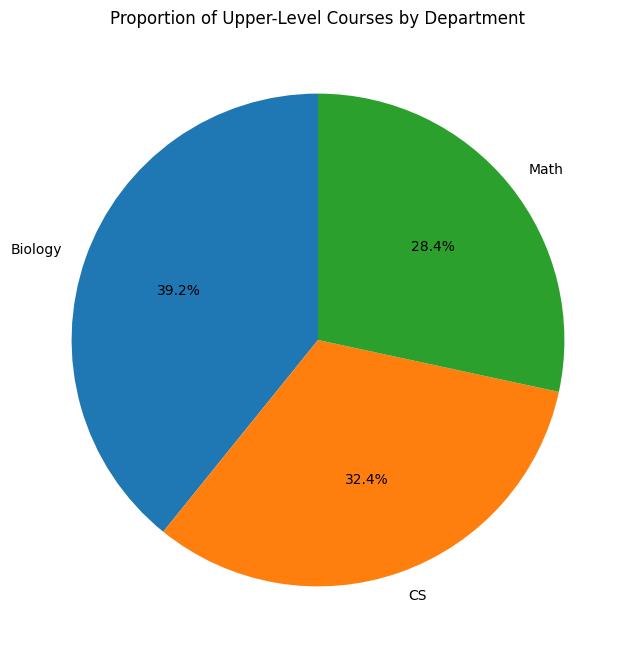

In [8]:
#other graphs(not choosing these just wanted to see the result more EDA)

upper_level = df_combined[df_combined['Course Level'].isin(['300', '400'])]
upper_counts = upper_level.groupby('Department').size().reset_index(name='Count')

plt.figure(figsize=(8, 8))
plt.pie(upper_counts['Count'], labels=upper_counts['Department'], autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Upper-Level Courses by Department')
plt.show()

### Why this chart/what it shows:

- Pie charts are ideal for showing part-to-whole relationships. Here, we can easily compare which department offers the most upper-level courses at a glance.

- The inclusion of percentages ( Biology: 39.2%) adds clarity and makes the proportions more understandable without needing to refer to raw numbers.

- Color Coding: Each department is color-coded, which makes the chart more visually accessible and easier to interpret.

### results/patterns:
- Biology offers the largest proportion of upper-level courses (39.2%).

- CS follows with 32.4%.

- Math offers the smallest share at 28.4%.


### Does it help?:
This graph is moderatly helpful as it shows the proportion of coruses offfered for each department however it does not show the individual course levels so it is not as helpful as the first distribution.

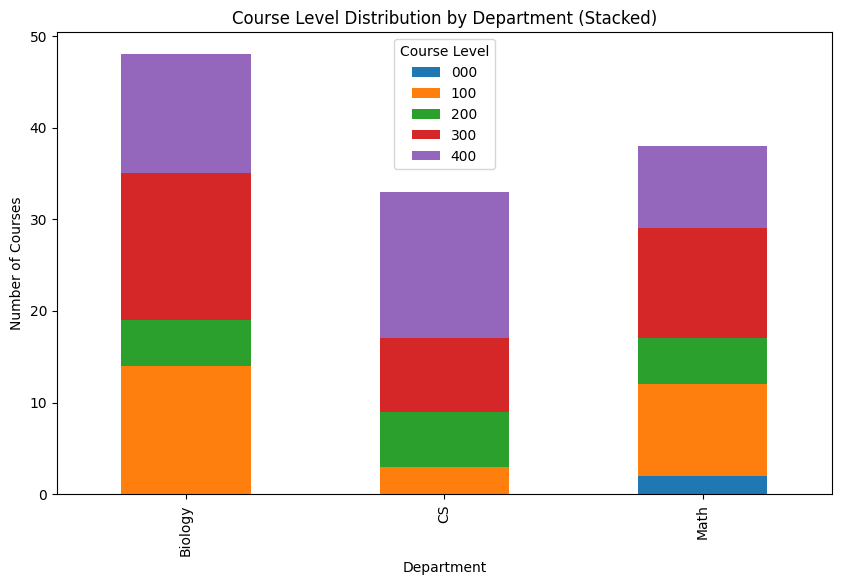

In [9]:
#other graphs(not choosing these just wanted to see the result more EDA)

level_counts = df_combined.groupby(['Department', 'Course Level']).size().reset_index(name='Count')

pivot_table = level_counts.pivot(index='Department', columns='Course Level', values='Count')
pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Course Level Distribution by Department (Stacked)')
plt.xlabel('Department')
plt.ylabel('Number of Courses')
plt.legend(title='Course Level')
plt.show()

### Why this chart

 Unlike a pie chart, this chart shows not just totals, but how courses are distributed across levels within each department.

 The stacking clearly shows which departments have more advanced (300/400 level) versus introductory (100/200) courses.

Additionally this makes it easy to compare course offerings both within a department and across departments.

### Key Findings:
- Biology offers the most 300- and 400-level courses, indicating a strong upper-level curriculum.

- CS has a balanced offering with a noticeable emphasis on upper-level (400-level) courses.

- Math offers the most 000-level courses (remedial or preparatory), with a steady presence across all levels.


### Does it help?:
Yes this chart is helpful it shows all three departmetns the frequeny of each course level however it is alittle hard to read in comparision to the first distribution.

## Answer to reseach question two.

`"2) What topics are most frequently mentioned in course descriptions?"`


### Prerequisite for Generating the Word Cloud
Before generating the word clouds, I noticed that many of the most frequent words were boilerplate phrases shared across all course descriptions—regardless of department or level. These included generic terms like "students," "course," and "prerequisites" that don't show any meaningful inofrmation. To correct for this and focus on  relevant keywords, I applied a custom list of stop words to filter out common academic language and improve the accuracy of the analysis.

`Additionally`, I separated the stop words into two categories: shared stop words and department-specific ones. Keeping all stop words in a single list was causing important keywords from specific departments to be incorrectly removed.

In [10]:
# Shared stopwords(across all depts, change this as needed if want to swap out keywords or modify the list below)
#https://www.geeksforgeeks.org/removing-stop-words-nltk-python/#types-of-stopwords
base_stopwords = STOPWORDS.union({
    'course', 'courses', 'students', 'including', 'topics', 'will', 'may', 'also',
    'used', 'use', 'study', 'introduction', 'description', 'provide', 'provides',
    'designed', 'offered', 'semester', 'department', 'credit', 'credits',
    'prerequisite', 'prerequisites', 'permission', 'instructor', 'include', 'take',
    'lecture', 'inventory', 'selected', 'required',"majors","Grading"
})


# CS-specific stopwords
cs_stopwords = base_stopwords.union({
    'cs', 'systems', 'problem', 'solving', 'programming', 'skills', 'computer',
    'data', 'based', 'approach', 'intensive', 'real', 'world', 'analysis',
    'information', 'applications', 'learn', 'language', 'languages', 'software',
    'technology', 'impact',"level"
})


# Math-specific stopwords
math_stopwords = base_stopwords.union({
    'math', 'mathematics', 'mathematical', 'methods', 'equations', 'theory',
    'basic', 'principles', 'functions', 'linear', 'algebra', 'geometry', 'discussed',
    'application', "098or","IB placement", "Level IB","IB placement","level","placement","skills",'applications',"real","solving",'number',
    'emphasis','ib','work'
})



# Bio-specific stopwords
bio_stopwords = base_stopwords.union({
    'biology', 'biol', 'biological', 'laboratory', 'senior', 'junior', 'major',
    'structure', 'function', 'concepts', 'level', 'explore', 'understanding',
    'perspectives', 'emphasize', 'emphasis', 'techniques', 'student', 'taking',
    'reading', 'finals', '203', '149', 'chem', 'introductory','without','110'
})


## Issues:
One issue I ran into during this project (which you might’ve noticed) is that some of the content scraped from the website included extra text above the main course descriptions. As far as I know, there’s no consistent way to remove that automatically. However, I found a bit of a workaround by adding some of those repeated phrases to the stop words list, which helped clean things up a bit.

In [11]:
#wrapped wordclouds into functions so we can call them repeatedly as needed if we pass in more course information
def generate_wordcloud(df, dept_name, stopwords):
    text_blob = ' '.join(df['Description'])
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        stopwords=stopwords
    ).generate(text_blob)


    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most Common Words in {dept_name} Course Descriptions')
    plt.show()


testing the wordcloud on the 3 dept from above:
the function is just for generating word clouds for each department as we will have t odo this for every dept.
Note: The custom stop words I added are open to interpretation I did the best I could to only include the words that I belvie have the most meaning so feel free to change them as needed.

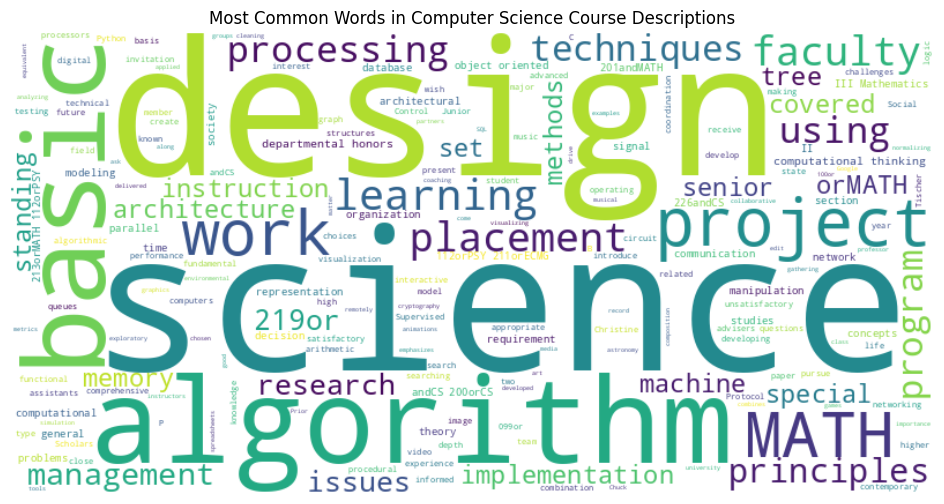

In [12]:
generate_wordcloud(df_cs, "Computer Science", cs_stopwords)

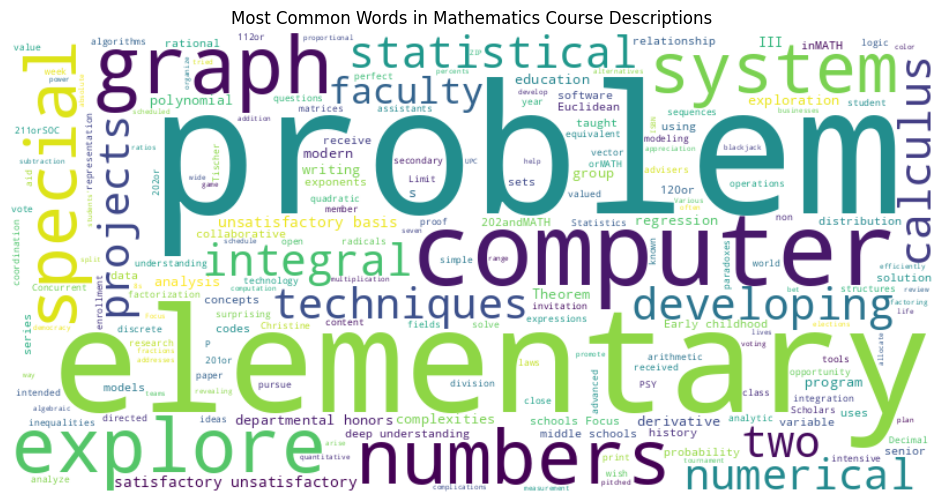

In [13]:
generate_wordcloud(df_math, "Mathematics", math_stopwords)

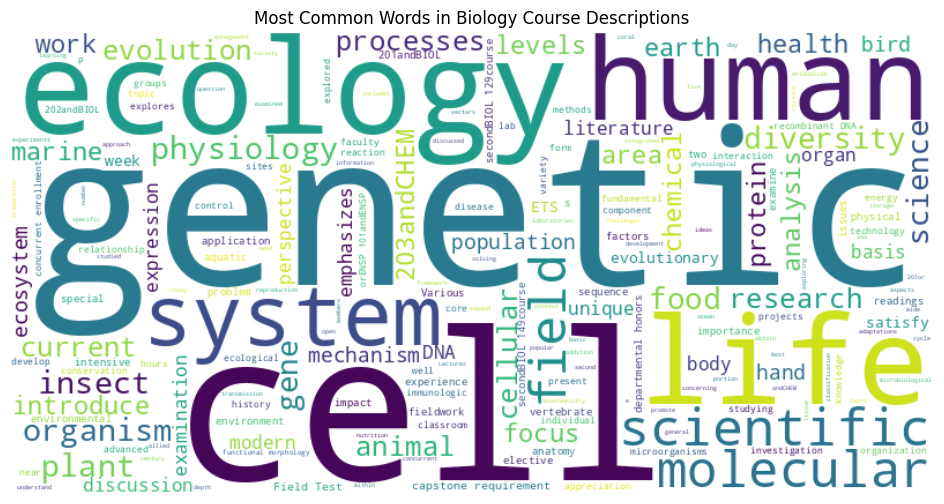

In [14]:
generate_wordcloud(df_bio, "Biology", bio_stopwords)

### Why these word clouds?

These word clouds display the most frequently used keywords in course descriptions for the CS, Math, and Biology departments. By visualizing the language used in each curriculum, we can quickly identify common themes, technical focuses, and departmental priorities without reading every description manually.

### What they show:

- In Computer Science, keywords like design, math, and processing appear frequently, highlighting a focus on technical skills and computing fundamentals.

- The Math word cloud emphasizes terms like graph, numerical, and problem solving, reflecting a curriculum centered on abstract reasoning and problem-solving.

- Biology features words such as genetic, scientific, and cells, pointing to hands-on scientific investigation and life sciences content.

### do they help answer the research question?
yes they do this visual is helpful becuase it dispay s the relative frequency of each word from our descriptino column in the dataframe this can allow us to amke preliminary assumptions based on the top 10 key words from this visual. However we will need to do an actual count to verify the findings are correct

## Finding the Most Frequent Keywords Across Departments
### Internal verfiication of EDA
In this section, I analyze the most commonly used words in course descriptions for the Computer Science, Mathematics, and Biology departments. By filtering out boilerplate academic language using a custom stop word list, I was able to focus on meaningful terms that reflect each department’s unique focus.

`Additionally` the world cloud is great for getting an intial visual of the data we are wokring with however it does not provide us with the actual counts of each word that is what I will be finding in this next code block to verify the results.

In [15]:
# function to get the actual counts of keywords excluding stop words above and running it on each dept
def get_top_keywords(df, dept_name, top_n=10):
    # Pick stopwords for the department
    if dept_name == "CS":
        stopwords = cs_stopwords
    elif dept_name == "Math":
        stopwords = math_stopwords
    elif dept_name == "Biology":
        stopwords = bio_stopwords
    else:
        stopwords = base_stopwords



    all_text = ' '.join(df['Description']).lower()
    words = re.findall(r'\b\w+\b', all_text)
    filtered_words = [word for word in words if word not in stopwords]
    word_counts = Counter(filtered_words)

    print(f"\nTop {top_n} keywords in {dept_name} course descriptions:")
    for word, count in word_counts.most_common(top_n):
        print(f"{word}: {count}")


      #run for each dept
get_top_keywords(df_cs, "CS")
get_top_keywords(df_math, "Math")
get_top_keywords(df_bio, "Biology")


Top 10 keywords in CS course descriptions:
design: 13
science: 12
basic: 9
algorithms: 9
math: 8
work: 8
learning: 8
placement: 7
computational: 7
faculty: 7

Top 10 keywords in Math course descriptions:
elementary: 9
problem: 8
computer: 8
numbers: 7
special: 6
explore: 6
problems: 6
graphs: 5
grading: 5
satisfactory: 5

Top 10 keywords in Biology course descriptions:
ecology: 13
field: 13
life: 11
scientific: 10
genetics: 10
molecular: 10
physiology: 9
human: 8
diversity: 8
food: 8


`results of code block`:
above are the list of the top 10 key words per department in course descriptions

**Which departments have the highest number of upper-level (300/400) courses?**
more EDA + ans

In [16]:
#same as other code block(kept getting error when i dont ahve first two lines)
df_all = pd.concat([df_cs, df_math, df_bio], ignore_index=True)
df_all['Course Level'] = df_all['Course Code'].apply(lambda x: x.split()[1][0] + "00")

# filter for 300 and 400 level courses
upper_level = df_all[df_all['Course Level'].isin(['300', '400'])]
upper_counts = upper_level['Department'].value_counts().reset_index()
upper_counts.columns = ['Department', 'Upper-Level Course Count']



print("Departments ranked by number of 300/400-level courses:")
print(upper_counts)

Departments ranked by number of 300/400-level courses:
  Department  Upper-Level Course Count
0    Biology                        29
1         CS                        24
2       Math                        21


`results of code block`: this is actually another answer to question 1 that shows biology has the ihghest number of upper level courses followed by CS and finally Math if the grpahs are not totally clear which dept has the highest level of courses

### Answer to research question three
`How are courses distributed across semesters?`

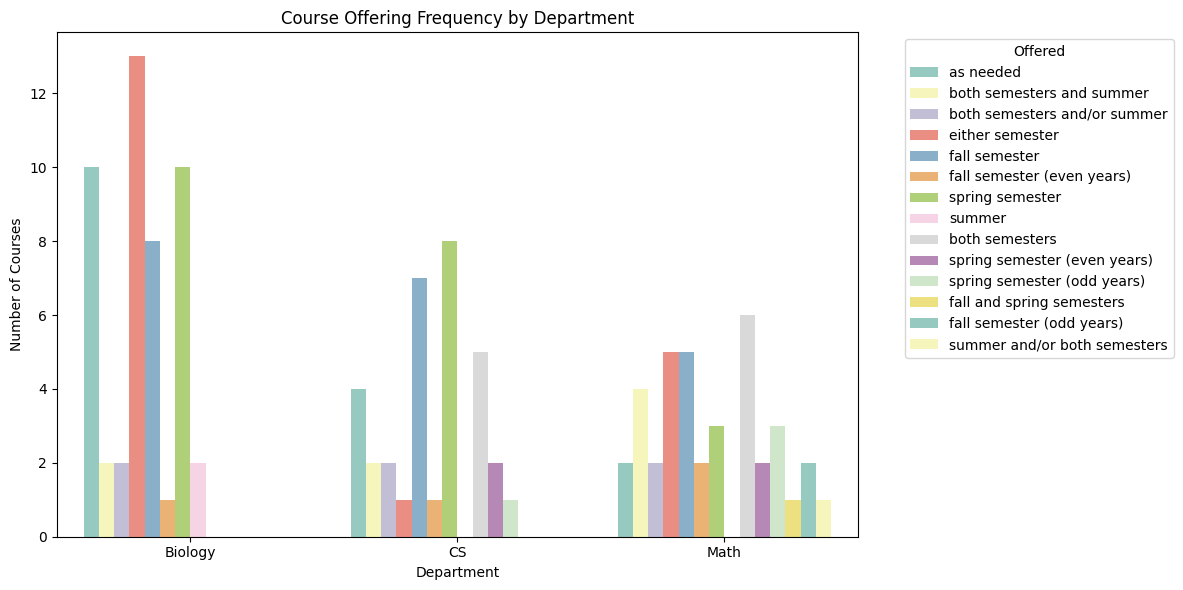

In [17]:
#get the frequency of offerings by dept

df_all['Offered'] = df_all['Offered'].fillna('Unknown').str.lower()

# group and count
offered_counts = df_all.groupby(['Department', 'Offered']).size().reset_index(name='Count')

plt.figure(figsize=(12, 6))
sns.barplot(data=offered_counts, x='Department', y='Count', hue='Offered', palette='Set3')
plt.title('Course Offering Frequency by Department')
plt.ylabel('Number of Courses')
plt.xlabel('Department')
plt.legend(title='Offered', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

 ### Why a bar chart?

A bar chart is an effective choice for this type of data because:

 The "Offered" variable is categorical, meaning it represents distinct groups or categories. Bar charts are designed to visualize the distribution of data across categories.

Comparison: Bar charts allow for easy comparison of the frequency or count of courses offered in each category. The height of each bar directly represents the number of courses, making it straightforward to identify patterns and differences.

### Findings

- `Biology` has the widest variety of offering terms, with many courses available in the fall, spring, or either semester, suggesting flexibility and higher course volume.

- `Computer Science` (CS) has a strong cluster around spring semester and either semester, indicating a focus on recurring core courses.

- `Math` shows more uniform distribution across terms, but fewer high-frequency offerings overall compared to Biology.

### Does it help?:
yes this helps answer our research question because much like the first bar chart in the beginning this one keeps that same style and instead useses when the courses are offered. This directly answers the third question by showing when each department offers its courses.



### Visual Summary and Reflections + solutions(recap)


To support my research questions, I created three primary visualizations:

- **Course Level Distribution Chart (Altair):**  
  Helps compare how departments distribute courses across levels, clearly showing CS's focus on 300-levels and Biology’s emphasis on 400-levels.

- **Department Word Clouds:**  
  Reveal the most emphasized themes in each curriculum by filtering out boilerplate terms. This visualization gives a quick, intuitive sense of department priorities.

- **Course Offering Frequency Chart (Seaborn):**  
  Highlights seasonal trends in how often courses are available. Math and CS offer more courses in both semesters, while Biology varies more.

These visuals answered the questions I had and helped me better understand how departments differ in focus and scheduling.


### Content learned from EDA:
1) Different Departments, Different Course Focus: The analysis of course level distribution revealed that each department has a distinct emphasis within their curriculum structure. Computer Science shows a strong concentration of courses at the 300 level, indicating a focus on advanced technical training. Biology, on the other hand, has a noticeable number of 400-level courses, which may reflect specialized, research-intensive, or lab-intensive classes in upper years. This finding highlights the varying priorities and academic approaches of different departments.


2) Each Field Has Its Own Language: The word clouds generated from course descriptions provided insights into the unique terminology and themes emphasized by each department. Computer Science emphasizes terms related to data, systems, and design, suggesting a focus on technical skills and computing fundamentals. Biology uses language related to organisms, cells, and scientific processes, pointing towards a focus on life sciences and experimental work. This finding showcases the distinct academic goals and language used in different fields of study.


## Overview of soltuions
`Research Question 1:`
Which departments offer more advanced (300/400 level) courses?

Findings:
Biology offers the most 400-level courses, likely lab-intensive or capstone experiences.
the runner up Computer Science focuses heavily on 300-level courses, reflecting advanced technical training.
finally Math has a balanced distribution, including 0-level and 300-level courses.

`Research Question 2:`
What topics are emphasized in course descriptions?

Findings:
CS emphasizes “design,” “math,” and “processing” — technical and system-level concepts.
Math frequently uses “problem,” “theory,” and “graph” — suggesting a focus on analytical reasoning.
Biology highlights “ecology,” “genetics,” and “scientific” — reinforcing its life science foundation.

 `Research Question 3:`
How are courses distributed across semesters?

Findings:
Biology has the highest number of courses offered across multiple terms, suggesting flexibility.
CS concentrates offerings in the Spring and “Both” semesters.
Math is more evenly spread but with lower overall course volume.



## Ethical Considerations

Although the data is publicly available, a few ethical considerations are worth noting:

- **Bias in course descriptions:** Language used in course descriptions may reflect institutional or disciplinary norms rather than actual course experience. This could lead to biased interpretations, especially when using word frequency analysis.


- **Data consistency:** Course descriptions vary in length and detail. Some may include rich, descriptive language while others are brief, which can skew keyword analysis.

- **Generalization limitations:** The findings apply only to the current academic year (2024–2025) and may not reflect trends across different years or institutions.

- **Stop words issue mentioned earier also in presentation**

## Conclusion

This project analyzed course offerings across three departments at Hood College. Computer Science, Mathematics, and Biology by scraping and examining data from the college catalog. Through structured exploratory analysis and visualization, I was able to answer three core research questions about curriculum design, course content, and availability.

Key Findings:

Curriculum Structure:
Biology places a strong emphasis on upper-level (400-level) courses, which may reflect advanced or lab-intensive requirements. Computer Science offers a high concentration of 300-level courses focused on advanced technical skills, while Math shows a more balanced spread across levels, including foundational (0-level) courses.


Course Content Themes:
Each department uses a unique language in its course descriptions. Computer Science frequently mentions terms related to design, systems, and data. Mathematics emphasizes problem-solving and theory, while Biology focuses on scientific terminology such as genetics, ecology, and physiology.


Semester Distribution:
Biology offers courses across more terms (Fall, Spring, and Both), indicating greater scheduling flexibility. Computer Science shows a stronger concentration of Spring courses, and Math is evenly distributed but offers fewer total courses.
